In [2]:
%matplotlib inline

import gym
import matplotlib
import numpy as np
import sys

from collections import defaultdict
if "../" not in sys.path:
  sys.path.append("../") 
from lib.envs.blackjack import BlackjackEnv
from lib import plotting

matplotlib.style.use('ggplot')

In [3]:
env = BlackjackEnv()

In [8]:
def make_epsilon_greedy_policy(Q, epsilon, nA):
    """
    Creates an epsilon-greedy policy based on a given Q-function and epsilon.
    
    Args:
        Q: A dictionary that maps from state -> action-values.
            Each value is a numpy array of length nA (see below)
        epsilon: The probability to select a random action . float between 0 and 1.
        nA: Number of actions in the environment.
    
    Returns:
        A function that takes the observation as an argument and returns
        the probabilities for each action in the form of a numpy array of length nA.
    
    """
    def policy_fn(observation):
        actions = np.zeros(env.action_space.n)
        action = np.ones(nA)
        action = np.argmax(Q[observation])
        actions[action] = 1 - epsilon
        
        actions += epsilon/nA
        
        return actions 
    
    return policy_fn

In [42]:
def mc_control_epsilon_greedy(env, num_episodes, discount_factor=1.0, epsilon=0.1):
    """
    Monte Carlo Control using Epsilon-Greedy policies.
    Finds an optimal epsilon-greedy policy.
    
    Args:
        env: OpenAI gym environment.
        num_episodes: Number of episodes to sample.
        discount_factor: Gamma discount factor.
        epsilon: Chance the sample a random action. Float betwen 0 and 1.
    
    Returns:
        A tuple (Q, policy).
        Q is a dictionary mapping state -> action values.
        policy is a function that takes an observation as an argument and returns
        action probabilities
    """
    
    # Keeps track of sum and count of returns for each state
    # to calculate an average. We could use an array to save all
    # returns (like in the book) but that's memory inefficient.
    returns_sum = defaultdict(float)
    returns_count = defaultdict(float)
    
    # The final action-value function.
    # A nested dictionary that maps state -> (action -> action-value).
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    
    # maps state -> action -> value 
    # visited = defaultdict(float)
    
    # The policy we're following
    policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)
    
    # Implement this!
    k = 0
    for i in range(num_episodes):
        # create an episode 
        traj = []
        
        state = env.reset()
        while True: 
            actions_prob = policy(state)
            chosen_action = np.random.choice(env.action_space.n, 1, p = actions_prob)[0]
            # print(chosen_action, actions_prob)
            next_state, reward, done, info = env.step(chosen_action)

            traj.append([state, chosen_action, reward])

            if done:
                break

            state = next_state
        
        # calculate return: g 
        # g = 0
        # for i in range(len(traj)):
        #     g += traj[i][1] * discount_factor ** i 
        
        # update Q 
        visited = defaultdict(float)
        t = 0
        for step in traj:
            sa_pair = (step[0], step[1])
            g = 0
            if visited[sa_pair] != 1:
                # not visited 
                for i in range(t, len(traj)):
                    g += discount_factor ** (t-i) * traj[i][2]
                returns_count[sa_pair] += 1
                returns_sum[sa_pair] += g
                Q[step[0]][step[1]] += (g - Q[step[0]][step[1]])/returns_count[sa_pair]
                # Q[step[0]][step[1]] += returns_sum[sa_pair] / returns_count[sa_pair]
                
                visited[sa_pair] = 1
            
            # g -= traj[t][1]
            # g /= discount_factor  
            t += 1
        policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n) 
        # k += 1 
        # epsilon = 1/k
    return Q, policy

In [43]:
Q, policy = mc_control_epsilon_greedy(env, num_episodes=500000, epsilon=0.1)

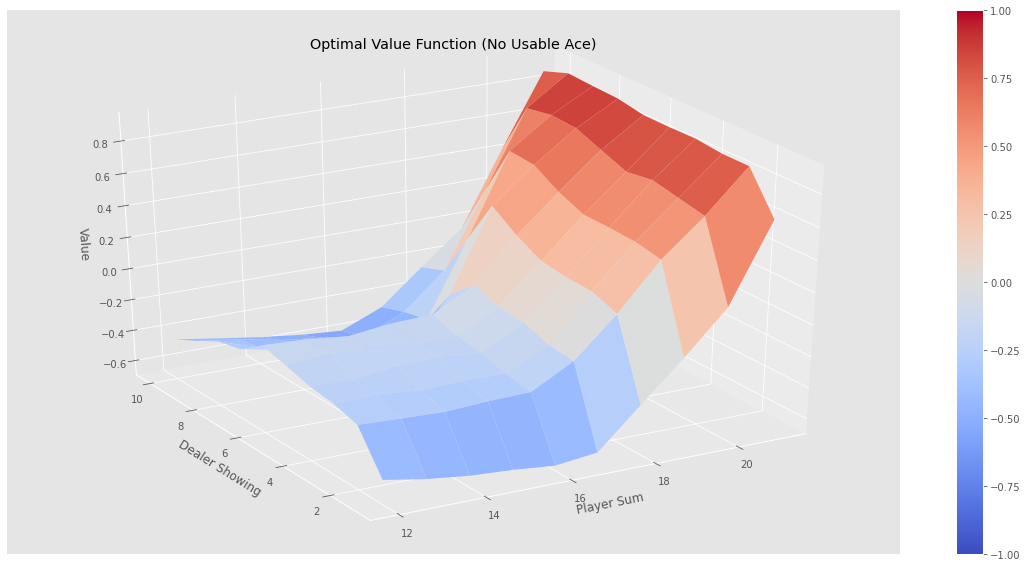

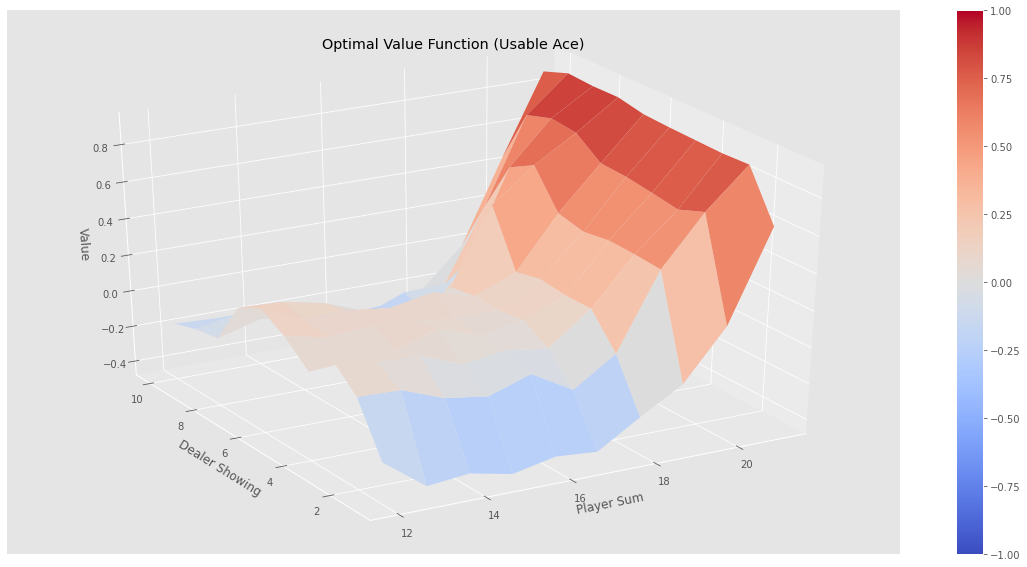

In [44]:
# For plotting: Create value function from action-value function
# by picking the best action at each state
V = defaultdict(float)
for state, actions in Q.items():
    action_value = np.max(actions)
    V[state] = action_value
plotting.plot_value_function(V, title="Optimal Value Function")